In [1]:
from scalecast.Forecaster import Forecaster
from scalecast.util import infer_apply_Xvar_selection, find_optimal_transformation
from scalecast.Pipeline import Pipeline, Transformer, Reverter
from scalecast import GridGenerator
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2020-12-31',
)

df.tail()

,HOUSTNSA
DATE,
2020-08-01,122.5
2020-09-01,126.3
2020-10-01,131.2
2020-11-01,117.8
2020-12-01,115.1


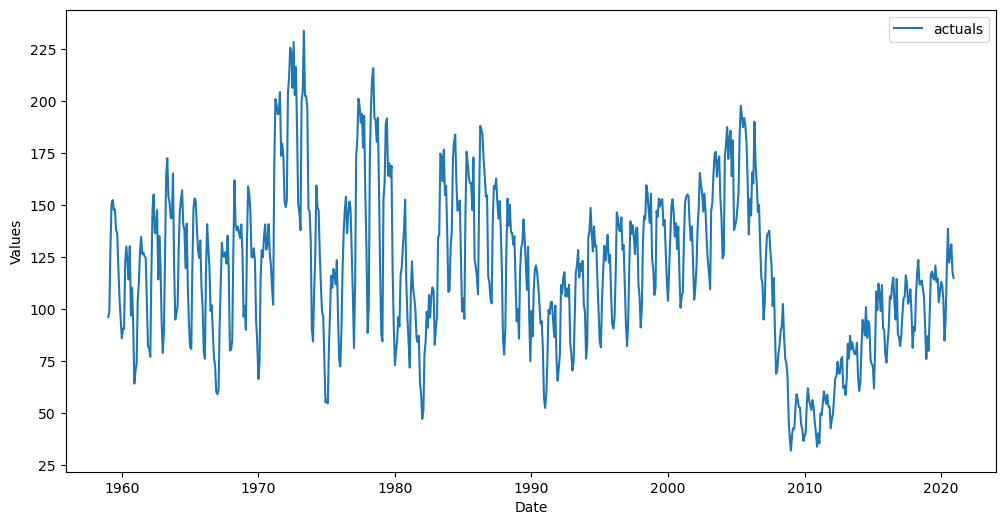

In [3]:
f = Forecaster(
    y = df.iloc[:,0],
    current_dates = df.index,
    future_dates = 24,
    #cis=True,
    #test_length = 24, # transferring confidence intervals is also possible!
)

f.plot()
plt.show()

In [4]:
f.set_estimator('lstm')
f.manual_forecast()

23/23 [==============================] - 0s 1ms/step


In [5]:
f.tf_model

In [6]:
df_new = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2023-06-30',
)

df_new.tail()

,HOUSTNSA
DATE,
2023-02-01,103.2
2023-03-01,114.0
2023-04-01,121.7
2023-05-01,146.0
2023-06-01,130.0


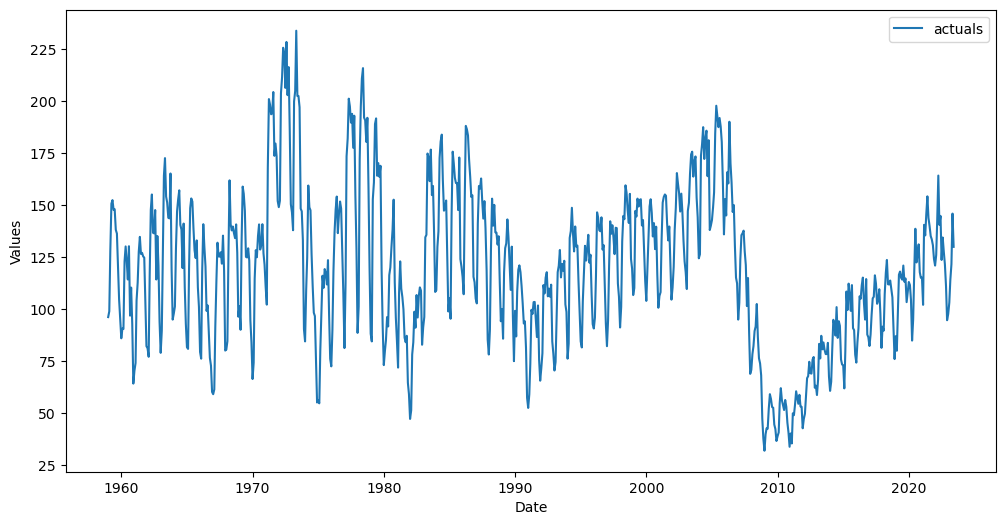

In [7]:
f_new = Forecaster(
    y = df_new.iloc[:,0],
    current_dates = df_new.index,
    future_dates = 24,
    #cis=True,
    #test_length = 24,
)

f_new.plot()
plt.show()

In [8]:
f_new.transfer_predict(transfer_from=f,model='lstm',model_type='tf')

KeyError: 'scale_X'

In [ ]:
f.history